In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf

In [2]:
from sklearn.cross_validation import train_test_split

/home/folzd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import edward as ed

In [4]:
from edward.models import Categorical, Dirichlet, InverseGamma, Normal
from edward.models import Categorical, Dirichlet, InverseGamma, Mixture, \
    MultivariateNormalDiag, Normal

In [5]:
def build_toy_dataset(N):
  pi = np.array([0.4, 0.6])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x

N = 5000  # number of data points
D = 2  # dimensionality of data

X = build_toy_dataset(N)

In [6]:
X_train, X_test = train_test_split(X,test_size=.9)

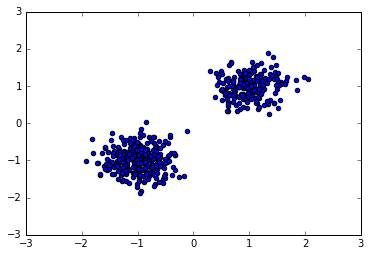

In [7]:
plt.scatter(X_train[:, 0], X_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.show()

In [8]:
N = X_train.shape[0]
N_test = X_test.shape[0]

In [9]:
alpha0 = 1

In [10]:
K = 2  # number of components

mu = Normal(mu=tf.zeros([K, D]), sigma=tf.ones([K, D]))
sigma = InverseGamma(alpha=tf.ones([K, D]), beta=tf.ones([K, D]))
pi = Dirichlet(tf.ones(K)*alpha0)
z = Categorical(p=tf.stack([pi]*N))
components = [
    MultivariateNormalDiag(mu=tf.ones([N, 1]) * tf.gather(mu, k),
                           diag_stdev=tf.ones([N, 1]) * tf.gather(sigma, k))
    for k in range(K)]
x = Mixture(cat=z, components=components)

In [11]:
qpi_alpha = tf.nn.softplus(tf.Variable(tf.random_normal([K])))
qmu_mu = tf.Variable(tf.random_normal([K, D]))
qmu_sigma = tf.nn.softplus(tf.Variable(tf.random_normal([K, D])))
qsigma_alpha = tf.nn.softplus(tf.Variable(tf.random_normal([K, D])))
qsigma_beta = tf.nn.softplus(tf.Variable(tf.random_normal([K, D])))

qpi = Dirichlet(alpha=qpi_alpha)
qmu = Normal(mu=qmu_mu, sigma=qmu_sigma)
qsigma = InverseGamma(alpha=qsigma_alpha, beta=qsigma_beta)

In [12]:
sigma,qsigma

(<ed.RandomVariable 'InverseGamma/' shape=(2, 2) dtype=tf.float32>,
 <ed.RandomVariable 'InverseGamma_1/' shape=(2, 2) dtype=tf.float32>)

In [12]:
inference = ed.KLqp({pi: qpi, mu: qmu, sigma: qsigma}, data={x: X_train})
#inference.run(n_iter=5000, n_samples=20) # spits out nan's
inference.run(n_iter=5000, n_samples=100)

Iteration    1 [  0%]: Loss = 3331.775
Iteration  500 [ 10%]: Loss = 1004.968
Iteration 1000 [ 20%]: Loss = 1508.342
Iteration 1500 [ 30%]: Loss = 1696.752
Iteration 2000 [ 40%]: Loss = 1395.107
Iteration 2500 [ 50%]: Loss = 1416.918
Iteration 3000 [ 60%]: Loss = 1247.392
Iteration 3500 [ 70%]: Loss = 1194.873
Iteration 4000 [ 80%]: Loss = 1158.556
Iteration 4500 [ 90%]: Loss = 1154.344
Iteration 5000 [100%]: Loss = 1130.918


In [13]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigma_sample = qsigma.sample(100)
x_post = Normal(mu=tf.ones([N, 1, 1, 1]) * mu_sample,
                sigma=tf.ones([N, 1, 1, 1]) * sigma_sample)
x_broadcasted = tf.tile(tf.reshape(X_train, [N, 1, 1, D]), [1, 100, K, 1])

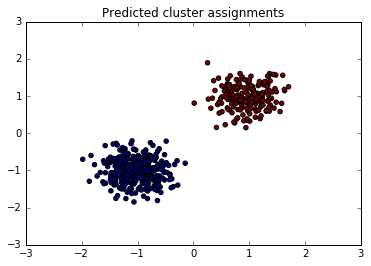

In [14]:
# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
clusters = tf.argmax(log_liks, 1).eval()
plt.scatter(X_train[:, 0], X_train[:, 1], c=clusters)#, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

In [15]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigma_sample = qsigma.sample(100)
x_post_pred = Normal(mu=tf.ones([N_test, 1, 1, 1]) * mu_sample,
                sigma=tf.ones([N_test, 1, 1, 1]) * sigma_sample)
x_broadcasted_pred = tf.tile(tf.reshape(X_test, [N_test, 1, 1, D]), [1, 100, K, 1])

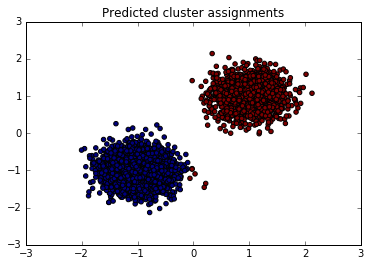

In [16]:
# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post_pred.log_prob(x_broadcasted_pred)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
clusters = tf.argmax(log_liks, 1).eval()
plt.scatter(X_test[:, 0], X_test[:, 1], c=clusters)#, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

In [29]:
log_liks.shape

TensorShape([Dimension(4500), Dimension(2)])

In [94]:
tf.reduce_max(log_liks, 1).eval().sum()

-4058.5015

In [96]:
np.max(log_liks.eval(),1).sum()

-4009.1621